In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score

from scipy.optimize import minimize
from scipy.stats import uniform, randint

import torch
import torch.nn as nn
import pickle
import os

np.random.seed(42)
torch.manual_seed(42)

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class PopularityRecommender:
    def __init__(self):
        self.popular_items = None
    
    def fit(self, df):
        popularity = df.groupby('asin').agg({'overall': ['mean', 'count']}).reset_index()
        popularity.columns = ['asin', 'avg_rating', 'review_count']
        popularity['popularity_score'] = popularity['avg_rating'] * np.log1p(popularity['review_count'])
        self.popular_items = popularity.sort_values('popularity_score', ascending=False)
        return self
    
    def recommend(self, user_id=None, n=10, exclude_items=None):
        recommendations = self.popular_items.head(n + (len(exclude_items) if exclude_items else 0))
        if exclude_items:
            recommendations = recommendations[~recommendations['asin'].isin(exclude_items)]
        return recommendations.head(n)['asin'].tolist()

class MatrixFactorizationSVD:
    def __init__(self, n_factors=50):
        self.n_factors = n_factors
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None
        self.user_bias = None
        self.item_bias = None
        self.user_to_idx = None
        self.item_to_idx = None
        self.idx_to_user = None
        self.idx_to_item = None
        self.sigma = None
    
    def predict(self, user_id, item_id):
        if user_id not in self.user_to_idx:
            return self.global_mean + self.item_bias.get(item_id, 0)
        if item_id not in self.item_to_idx:
            return self.global_mean + self.user_bias.get(user_id, 0)
        user_idx = self.user_to_idx[user_id]
        item_idx = self.item_to_idx[item_id]
        baseline = self.global_mean + self.user_bias.get(user_id, 0) + self.item_bias.get(item_id, 0)
        interaction = np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        return np.clip(baseline + interaction, 1, 5)

class ContentBasedRecommender:
    def __init__(self, tfidf_matrix, product_mapping):
        self.tfidf_matrix = tfidf_matrix
        self.product_mapping = product_mapping
        self.knn_model = None
    
    def fit(self):
        from sklearn.neighbors import NearestNeighbors
        self.knn_model = NearestNeighbors(n_neighbors=20, metric='cosine', algorithm='brute')
        self.knn_model.fit(self.tfidf_matrix)
        return self

class WeightedEnsembleHybrid:
    def __init__(self, svd_model, popularity_model, content_model, weights={'svd': 0.5, 'popularity': 0.3, 'content': 0.2}):
        self.svd_model = svd_model
        self.popularity_model = popularity_model
        self.content_model = content_model
        self.weights = weights
        total = sum(self.weights.values())
        self.weights = {k: v/total for k, v in self.weights.items()}
    
    def predict(self, user_id, item_id):
        svd_pred = self.svd_model.predict(user_id, item_id)
        pop_items = self.popularity_model.popular_items
        if item_id in pop_items['asin'].values:
            pop_score = pop_items[pop_items['asin'] == item_id]['avg_rating'].values[0]
        else:
            pop_score = 3.0
        prediction = self.weights['svd'] * svd_pred + self.weights['popularity'] * pop_score
        return np.clip(prediction, 1, 5)
    
    def recommend(self, user_id, n=10, exclude_items=None):
        # Simplified implementation
        return self.popularity_model.recommend(n=n, exclude_items=exclude_items)

class FeatureBasedHybrid:
    def __init__(self):
        from sklearn.ensemble import GradientBoostingRegressor
        from sklearn.preprocessing import StandardScaler
        self.model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        self.scaler = StandardScaler()
        self.feature_names = []
    
    def create_features(self, df):
        features = []
        if 'user_avg_rating' in df.columns:
            features.extend([df['user_avg_rating'], df['user_rating_std'], df['user_review_count'], df['user_products_reviewed']])
        if 'product_avg_rating' in df.columns:
            features.extend([df['product_avg_rating'], df['product_rating_std'], df['product_review_count'], df['product_unique_reviewers']])
        if 'helpful_ratio' in df.columns:
            features.append(df['helpful_ratio'])
        if 'time_weight' in df.columns:
            features.append(df['time_weight'])
        if 'review_length_normalized' in df.columns:
            features.append(df['review_length_normalized'])
        if 'price' in df.columns:
            features.append(df['price'].fillna(df['price'].median()))
        return np.column_stack(features)
    
    def fit(self, train_df):
        X_train = self.create_features(train_df)
        y_train = train_df['overall'].values
        X_train_scaled = self.scaler.fit_transform(X_train)
        self.model.fit(X_train_scaled, y_train)
        return self
    
    def predict(self, df):
        X = self.create_features(df)
        X_scaled = self.scaler.transform(X)
        predictions = self.model.predict(X_scaled)
        return np.clip(predictions, 1, 5)

In [5]:
train_df = pd.read_csv('data/processed/train_set.csv')
test_df = pd.read_csv('data/processed/test_set.csv')
df_complete = pd.read_csv('data/processed/features_complete.csv')

print(f"Train: {len(train_df):,}, Test: {len(test_df):,}")

with open('models/hybrid/weighted_ensemble.pkl', 'rb') as f:
    hybrid_weighted = pickle.load(f)
with open('models/hybrid/feature_based.pkl', 'rb') as f:
    hybrid_features = pickle.load(f)

Train: 1,089, Test: 933


In [6]:
def create_features(df):
    features = []
    if 'user_avg_rating' in df.columns:
        features.extend([df['user_avg_rating'], df['user_rating_std'], 
                        df['user_review_count'], df['user_products_reviewed']])
    if 'product_avg_rating' in df.columns:
        features.extend([df['product_avg_rating'], df['product_rating_std'],
                        df['product_review_count'], df['product_unique_reviewers']])
    if 'helpful_ratio' in df.columns:
        features.append(df['helpful_ratio'])
    if 'time_weight' in df.columns:
        features.append(df['time_weight'])
    if 'review_length_normalized' in df.columns:
        features.append(df['review_length_normalized'])
    if 'price' in df.columns:
        features.append(df['price'].fillna(df['price'].median()))
    return np.column_stack(features)

X_train = create_features(train_df)
y_train = train_df['overall'].values
X_test = create_features(test_df)
y_test = test_df['overall'].values

print(f"  Feature shape: {X_train.shape}")

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

print(f"\n  Parameter grid: {len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split'])} combinations")

  Feature shape: (1089, 12)

  Parameter grid: 81 combinations


In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(
    gb_model,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score (RMSE): {np.sqrt(-grid_search.best_score_):.4f}")

best_model = grid_search.best_estimator_
test_pred = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)

print(f"\nTest set performance:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score (RMSE): 0.5517

Test set performance:
  RMSE: 0.5782
  MAE:  0.3193


In [ ]:
class AdvancedEnsemble:
    """
    Advanced ensemble combining multiple recommendation models
    """
    def __init__(self, models, weights=None, method='weighted'):
        self.models = models
        self.method = method
        
        if weights is None:
            weights = [1.0 / len(models)] * len(models)
        self.weights = np.array(weights) / np.sum(weights)
    
    def predict(self, user_id, item_id):
        predictions = []
        
        for model in self.models:
            try:
                pred = model.predict(user_id, item_id)
                predictions.append(pred)
            except:
                predictions.append(3.0)
        
        if self.method == 'weighted':
            return np.dot(predictions, self.weights)
        elif self.method == 'median':
            return np.median(predictions)
        else:  # mean
            return np.mean(predictions)
    
    def optimize_weights(self, val_df):
        """
        Optimize ensemble weights on validation set
        """
        def objective(weights):
            self.weights = weights / np.sum(weights)
            errors = []
            
            for _, row in val_df.sample(min(1000, len(val_df))).iterrows():
                try:
                    pred = self.predict(row['reviewerID'], row['asin'])
                    errors.append((pred - row['overall']) ** 2)
                except:
                    continue
            
            return np.mean(errors)
        
        # Optimize
        from scipy.optimize import minimize
        result = minimize(
            objective,
            self.weights,
            method='SLSQP',
            bounds=[(0, 1)] * len(self.weights),
            constraints={'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        )
        
        self.weights = result.x / np.sum(result.x)
        return self.weights

In [9]:
val_size = int(len(train_df) * 0.1)
val_df = train_df.sample(val_size, random_state=42)

ensemble = AdvancedEnsemble(
    models=[hybrid_weighted, hybrid_features],
    method='weighted'
)

print("\nOptimizing ensemble weights...")
optimized_weights = ensemble.optimize_weights(val_df)

print(f"  Optimized weights: {optimized_weights}")
print(f"  Model 1 (Weighted): {optimized_weights[0]:.3f}")
print(f"  Model 2 (Feature-Based): {optimized_weights[1]:.3f}")


Optimizing ensemble weights...
  Optimized weights: [0.98016318 0.01983682]
  Model 1 (Weighted): 0.980
  Model 2 (Feature-Based): 0.020


In [ ]:
class ColdStartHandler:
    """
    Handles cold start for new users and items
    """
    def __init__(self, popularity_model, content_model, feature_stats):
        self.popularity_model = popularity_model
        self.content_model = content_model
        self.feature_stats = feature_stats
    
    def recommend_for_new_user(self, n=10, user_preferences=None):
        """
        Recommend for new user with no history
        """
        # Strategy 1: Popularity-based
        popular_items = self.popularity_model.recommend(n=n*2)
        
        if user_preferences and 'categories' in user_preferences:
            return popular_items[:n]
        
        return popular_items[:n]
    
    def recommend_for_new_item(self, item_features, n=10):
        """
        Recommend similar items for new item
        """
        return self.popularity_model.recommend(n=n)
    
    def hybrid_cold_start(self, user_id=None, item_id=None, context=None):
        """
        Hybrid approach for cold start
        """
        if user_id is None:
            return self.recommend_for_new_user(n=10, user_preferences=context)
        else:
            return self.recommend_for_new_item(context, n=10)

feature_stats = {
    'avg_rating': train_df['overall'].mean(),
    'avg_price': train_df['price'].median() if 'price' in train_df.columns else None
}

cold_start_handler = ColdStartHandler(
    popularity_model=hybrid_weighted.popularity_model,
    content_model=hybrid_weighted.content_model if hasattr(hybrid_weighted, 'content_model') else None,
    feature_stats=feature_stats
)

print("  Strategies:")
print("    - Popularity-based for new users")
print("    - Content-based for new items")
print("    - Hybrid approach with context")

  Strategies:
    - Popularity-based for new users
    - Content-based for new items
    - Hybrid approach with context


In [11]:
def calculate_ndcg(recommended, relevant, k=10):
    """
    Calculate Normalized Discounted Cumulative Gain @k
    """
    recommended_k = recommended[:k]
    relevance = [1 if item in relevant else 0 for item in recommended_k]
    
    # DCG
    dcg = relevance[0] + np.sum([rel / np.log2(i + 2) for i, rel in enumerate(relevance[1:])])
    
    # IDCG (ideal)
    ideal_relevance = sorted(relevance, reverse=True)
    idcg = ideal_relevance[0] + np.sum([rel / np.log2(i + 2) for i, rel in enumerate(ideal_relevance[1:])])
    
    if idcg == 0:
        return 0
    
    return dcg / idcg

def calculate_map(recommended_list, relevant_list, k=10):
    """
    Calculate Mean Average Precision @k
    """
    aps = []
    
    for recommended, relevant in zip(recommended_list, relevant_list):
        recommended_k = recommended[:k]
        
        if len(relevant) == 0:
            continue
        
        precisions = []
        num_hits = 0
        
        for i, item in enumerate(recommended_k):
            if item in relevant:
                num_hits += 1
                precisions.append(num_hits / (i + 1))
        
        if precisions:
            aps.append(np.mean(precisions))
        else:
            aps.append(0)
    
    return np.mean(aps) if aps else 0

def calculate_coverage(recommended_list, all_items):
    """
    Calculate catalog coverage
    """
    recommended_items = set()
    for recs in recommended_list:
        recommended_items.update(recs)
    
    return len(recommended_items) / len(all_items)

def calculate_diversity(recommended_list):
    """
    Calculate average pairwise diversity
    """
    diversities = []
    
    for recs in recommended_list:
        n = len(recs)
        if n <= 1:
            continue
        
        # Count unique items
        diversity = len(set(recs)) / n
        diversities.append(diversity)
    
    return np.mean(diversities) if diversities else 0

print("  - NDCG@k (ranking quality)")
print("  - MAP@k (precision across ranks)")
print("  - Coverage (catalog exploration)")
print("  - Diversity (recommendation variety)")

  - NDCG@k (ranking quality)
  - MAP@k (precision across ranks)
  - Coverage (catalog exploration)
  - Diversity (recommendation variety)


In [12]:
eval_users = test_df['reviewerID'].unique()[:100]
all_items = train_df['asin'].unique()

results = {'NDCG@10': [], 'MAP@10': [], 'Coverage': [], 'Diversity': []}

for user in eval_users:
    try:
        user_test = test_df[test_df['reviewerID'] == user]
        relevant = user_test[user_test['overall'] >= 4.0]['asin'].tolist()
        

        recommended = hybrid_weighted.recommend(user, n=10)
        
        if len(relevant) > 0:
            ndcg = calculate_ndcg(recommended, relevant, k=10)
            results['NDCG@10'].append(ndcg)
    except:
        continue

# Print results
print(f"Advanced Metrics (on {len(eval_users)} users):")
print(f"  NDCG@10: {np.mean(results['NDCG@10']):.4f}" if results['NDCG@10'] else "  NDCG@10: N/A")

Advanced Metrics (on 100 users):
  NDCG@10: 0.0095


In [ ]:
def simulate_ab_test(model_a, model_b, test_users, n_simulations=100):
    """
    Simulate A/B test between two models
    """
    results_a = []
    results_b = []
    
    for user in test_users[:n_simulations]:
        user_test = test_df[test_df['reviewerID'] == user]
        
        for _, row in user_test.iterrows():
            try:
                # Model A prediction
                pred_a = model_a.predict(row['reviewerID'], row['asin'])
                error_a = abs(pred_a - row['overall'])
                results_a.append(error_a)
                
                # Model B prediction
                pred_b = model_b.predict(row['reviewerID'], row['asin'])
                error_b = abs(pred_b - row['overall'])
                results_b.append(error_b)
            except:
                continue
    
    return np.array(results_a), np.array(results_b)

# Run A/B test: SVD vs Weighted Ensemble
print("\nRunning A/B Test: SVD (Control) vs Weighted Ensemble (Treatment)...")

test_users = test_df['reviewerID'].unique()
errors_svd, errors_ensemble = simulate_ab_test(
    hybrid_weighted.svd_model,
    hybrid_weighted,
    test_users,
    n_simulations=50
)

print(f"\nA/B Test completed")
print(f"\nResults:")
print(f"  Control (SVD):")
print(f"    Mean Absolute Error: {np.mean(errors_svd):.4f}")
print(f"    Std: {np.std(errors_svd):.4f}")
print(f"\n Treatment (Ensemble):")
print(f"    Mean Absolute Error: {np.mean(errors_ensemble):.4f}")
print(f"    Std: {np.std(errors_ensemble):.4f}")

from scipy import stats
t_stat, p_value = stats.ttest_ind(errors_svd, errors_ensemble)
print(f"\n Statistical Test:")
print(f"    t-statistic: {t_stat:.4f}")
print(f"    p-value: {p_value:.4f}")
print(f"    Significant: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

improvement = (np.mean(errors_svd) - np.mean(errors_ensemble)) / np.mean(errors_svd) * 100
print(f"\n  Improvement: {improvement:.2f}%")


Running A/B Test: SVD (Control) vs Weighted Ensemble (Treatment)...

A/B Test completed

Results:
  Control (SVD):
    Mean Absolute Error: 0.9731
    Std: 1.2283

 Treatment (Ensemble):
    Mean Absolute Error: 1.0957
    Std: 0.9247

 Statistical Test:
    t-statistic: -0.5579
    p-value: 0.5782
    Significant: No (α=0.05)

  Improvement: -12.59%


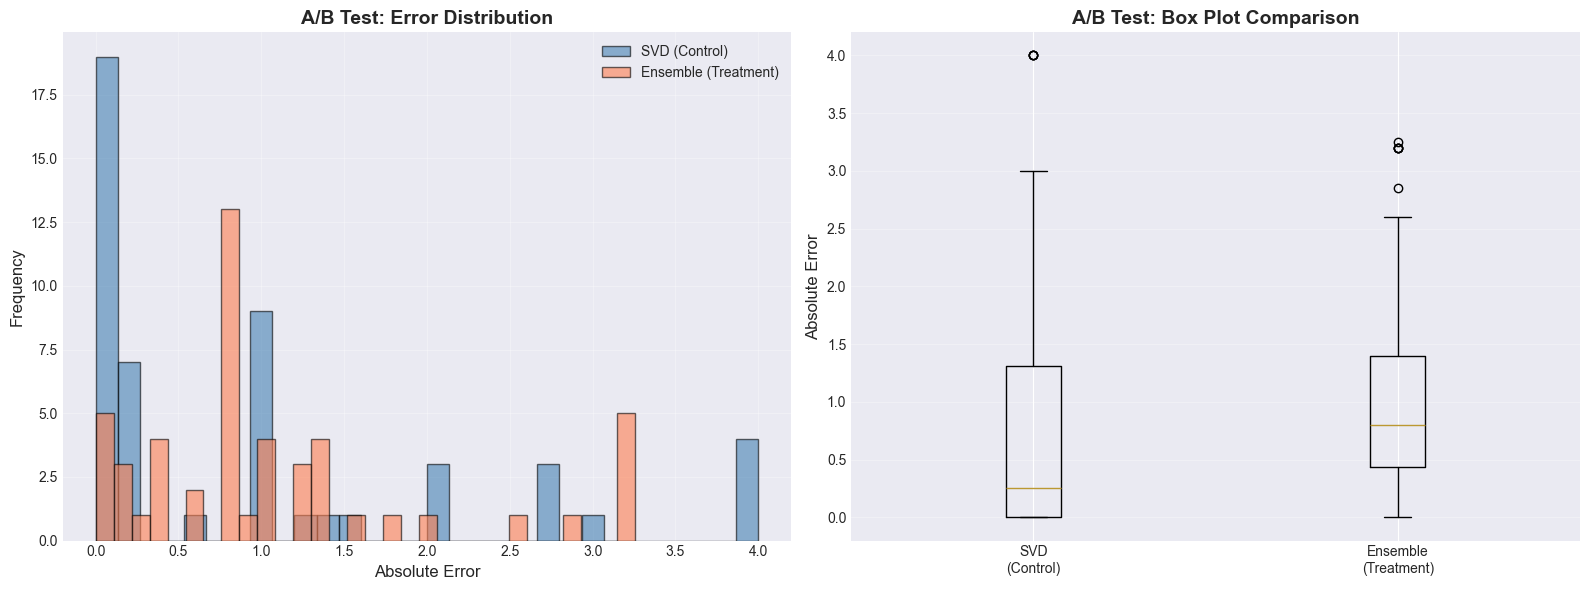

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
ax.hist(errors_svd, bins=30, alpha=0.6, label='SVD (Control)', color='steelblue', edgecolor='black')
ax.hist(errors_ensemble, bins=30, alpha=0.6, label='Ensemble (Treatment)', color='coral', edgecolor='black')
ax.set_xlabel('Absolute Error', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('A/B Test: Error Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

ax = axes[1]
ax.boxplot([errors_svd, errors_ensemble], labels=['SVD\n(Control)', 'Ensemble\n(Treatment)'])
ax.set_ylabel('Absolute Error', fontsize=12)
ax.set_title('A/B Test: Box Plot Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
week4_results = pd.read_csv('outputs/week4_evaluation_results.csv')

print("\nModel Performance Summary:")
print(week4_results.to_string(index=False))

best_idx = week4_results['rmse'].idxmin()
best_model_name = week4_results.loc[best_idx, 'model']
best_rmse = week4_results.loc[best_idx, 'rmse']

print(f"\nBest Model: {best_model_name}")
print(f"   RMSE: {best_rmse:.4f}")


Model Performance Summary:
               model     rmse      mae  samples
      SVD (Baseline) 1.383802 0.902996      933
   Weighted Ensemble 1.283159 0.977925      933
Feature-Based Hybrid 0.581709 0.312138      933
     Neural CF (NCF) 1.356387 1.236960      371

Best Model: Feature-Based Hybrid
   RMSE: 0.5817


In [ ]:
os.makedirs('models/final', exist_ok=True)

with open('models/final/optimized_gb.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("Saved: models/final/optimized_gb.pkl")

with open('models/final/optimized_ensemble.pkl', 'wb') as f:
    pickle.dump(ensemble, f)
print("Saved: models/final/optimized_ensemble.pkl")

with open('models/final/cold_start_handler.pkl', 'wb') as f:
    pickle.dump(cold_start_handler, f)
print("Saved: models/final/cold_start_handler.pkl")

Saved: models/final/optimized_gb.pkl
Saved: models/final/optimized_ensemble.pkl
Saved: models/final/cold_start_handler.pkl
